In [1]:
import warnings
import numpy as np
import numba
import matplotlib.pyplot as plt
from coffea.nanoevents import NanoEventsFactory
import awkward as ak
import pandas as pd
import json

/cvmfs/cms.cern.ch/slc7_amd64_gcc10/external/py3-setuptools/60.9.3-ddcab3b6a742c72fed5554de8ccaaf18/lib/python3.9/site-packages/_distutils_hack/__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/cvmfs/cms.cern.ch/slc7_amd64_gcc10/external/py3-setuptools/60.9.3-ddcab3b6a742c72fed5554de8ccaaf18/lib/python3.9/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [2]:
fn = "VBF_SMEFTsim_topU3l_NP1_123.root"
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    events = NanoEventsFactory.from_root(fn).events()

In [3]:
mjj = (ak.firsts(events.GenJet[0:1])+ak.firsts(events.GenJet[1:2])).mass

In [4]:
pth = events.GenPart[events.GenPart.pdgId==25].pt

In [5]:
with open('dictionary.json') as f:
    d = json.load(f)

In [6]:
def weight_names(reweight_card):
    
    array = []
    
    weight_index = 0
    
    with open(reweight_card, "r+") as file1:
        for line in file1.readlines():
            
            if 'launch' in line:
                weight_index += 1
                continue
                
            if 'rwgt' in line:
                continue
                
            array += [[weight_index]+line.split()[1:]]
            
        # Reading from a file
        #whole_file = file1.read()
        
    #points = whole_file.split('\n')
    #print(points)
    
    
    #df = pd.read_csv(reweight_card,sep=' ',skiprows=1,header=None,usecols=[1,2,3])
    #df = df[df[3]>0]
    #print(df)
    
    
    df = pd.DataFrame(array,columns=['weight_index','model','param_index','value'])
    df['value'] = df['value'].astype('float')
    df = df[df['value']>0]
    
    param_name = []
    for index, row in df.iterrows():
        param_name += [d[row['model']][row['param_index']]]
    
    df['param_name'] = param_name

    
    df['weight_name'] = df['param_name']+"="+df['value'].astype('string')
    
    names = []
    for i in np.unique(df['weight_index']):
        name = ""
        for n in df[df['weight_index']==i]["weight_name"]:
            if len(name)>0:
                name += ","
            name += n
        names += [name]

    return names

def param_names(reweight_card):
    df = pd.read_csv(reweight_card,sep=' ',skiprows=2,header=None)
    print(df)
    #df = df[[1,2,3]][(df[1]=="SMEFT") | (df[1]=="SMEFTcpv")].drop_duplicates()

In [7]:
names = weight_names("VBF_SMEFTsim_topU3l_NP1_reweight_card.dat")

In [8]:
def plot_variations(var, bins, name, plot_all=False):

    for i in range(len(events.LHEReweightingWeight[0])):
        if not plot_all:
            if ',' in names[i] or '5' in names[i]:
                continue
        
        plt.hist(events.GenJet.pt[:,0:1],weights=events.LHEReweightingWeight[:,i],histtype='step',bins=bins,label=names[i])

    plt.hist(events.GenJet.pt[:,0:1],histtype='step',bins=bins,label='SM',color='black')
    plt.yscale('log')
    plt.ylabel('Events')
    plt.xlabel(name)

    plt.legend(frameon=False,bbox_to_anchor=(1.1, 1),ncol=4)

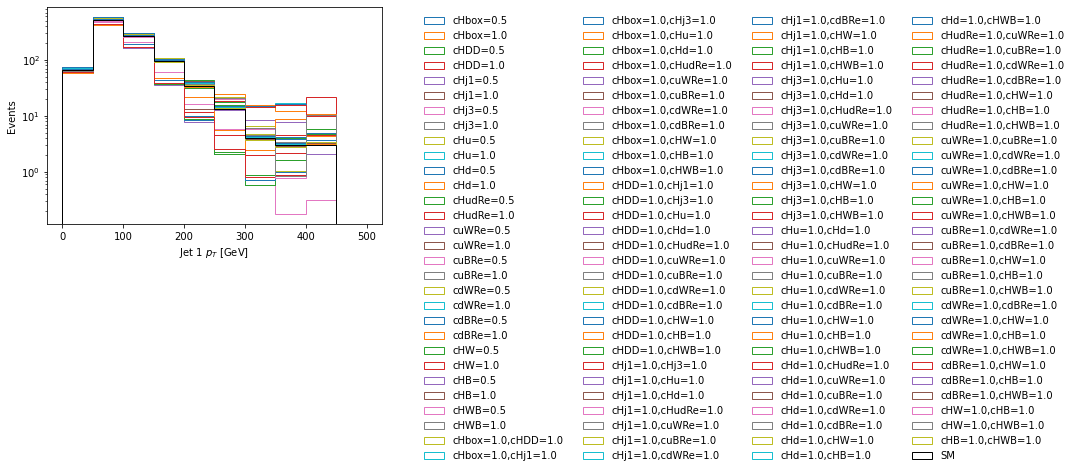

In [9]:
plot_variations(events.GenJet.pt[:,0:1],np.linspace(0,500,11),r'Jet 1 $p_T$ [GeV]',plot_all=True)

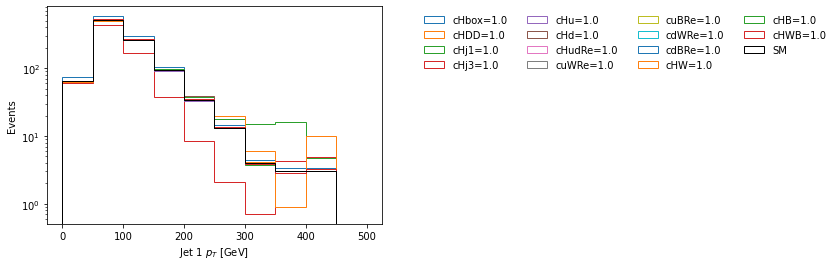

In [10]:
plot_variations(events.GenJet.pt[:,0:1],np.linspace(0,500,11),r'Jet 1 $p_T$ [GeV]')

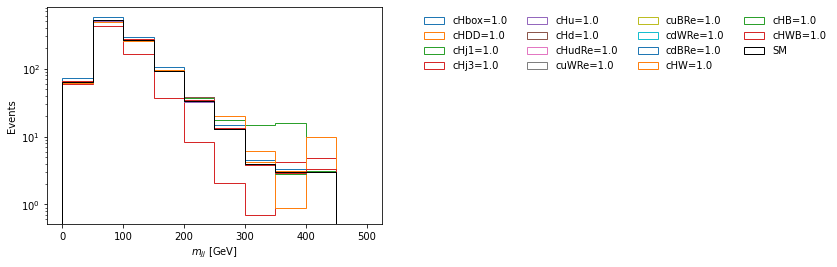

In [17]:
plot_variations(mjj,np.linspace(0,500,11),r'$m_{jj}$ [GeV]')

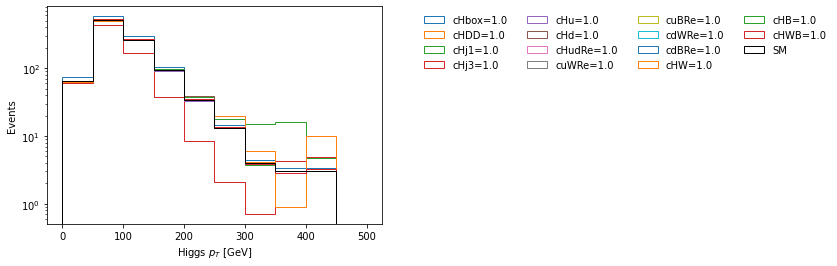

In [16]:
plot_variations(pth,np.linspace(0,500,11),r'Higgs $p_T$ [GeV]')